### Running MAST and testing the calibration

In [1]:
library(MAST)
library(Seurat)
library(SeuratData)
library(cowplot)
library(patchwork)
library(data.table)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

### Entire dataset

In [2]:
# InstallData('ifnb')

In [4]:
install.packages("https://seurat.nygenome.org/src/contrib/ifnb.SeuratData_3.1.0.tar.gz", repos = NULL, type = "source")

Warning message in download.file(p, destfile, method, mode = "wb", ...):
“downloaded length 159719038 != reported length 413266233”
Warning message in download.file(p, destfile, method, mode = "wb", ...):
“URL 'https://seurat.nygenome.org/src/contrib/ifnb.SeuratData_3.1.0.tar.gz': Timeout of 60 seconds was reached”


Error in download.file(p, destfile, method, mode = "wb", ...) : 
  download from 'https://seurat.nygenome.org/src/contrib/ifnb.SeuratData_3.1.0.tar.gz' failed


In [10]:
library(ifnb.SeuratData)

In [11]:
data("ifnb")

In [12]:
ifnb <- subset(x = ifnb, subset = seurat_annotations == "CD14 Mono")

In [13]:
ifnb <- NormalizeData(object = ifnb)

In [14]:
ifnb$stim = sample(as.vector(ifnb$stim))

In [15]:
expressed_genes = rowMeans(as.matrix(GetAssayData(object = ifnb,slot="counts"))) > 0.07

In [16]:
data = ifnb[expressed_genes,]

In [17]:
scaRaw <- FromMatrix(
    as.matrix(GetAssayData(object = ifnb,slot="data")), 
    ifnb[[]], ifnb[["RNA"]][[]])

`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.



In [18]:
sca <- scaRaw

In [19]:
sca

class: SingleCellAssay 
dim: 14053 4362 
metadata(0):
assays(1): et
rownames(14053): AL627309.1 RP11-206L10.2 ... AP001062.7 LRRC3DN
rowData names(1): primerid
colnames(4362): AAACATACATTTCC.1 AAACATACCAGAAA.1 ... TTTGACTGCCCACT.1
  TTTGACTGCCCTAC.1
colData names(6): orig.ident nCount_RNA ... seurat_annotations wellKey
reducedDimNames(0):
altExpNames(0):

In [20]:
# thres <- thresholdSCRNACountMatrix(assay(sca), nbins = 20, min_per_bin = 30)


In [21]:
# freq_expressed <- 0.0005

In [22]:
# assays(sca, withDimnames = FALSE) <- list(thresh=thres$counts_threshold, tpm=assay(sca))
# expressed_genes <- freq(sca) > freq_expressed


In [23]:
sum(expressed_genes)

[1] 2572

In [24]:
sca <- sca[expressed_genes,]

In [33]:
head(ifnb[[]])

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations
,<chr>,<dbl>,<int>,<chr>,<fct>
AAACATACATTTCC.1,IMMUNE_CTRL,3017,877,CTRL,CD14 Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481,713,CTRL,CD14 Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420,850,CTRL,CD14 Mono
AAACATACGGCATT.1,IMMUNE_CTRL,1581,557,STIM,CD14 Mono
AAACATTGCTTCGC.1,IMMUNE_CTRL,2536,669,CTRL,CD14 Mono
AAACGCACTCGCCT.1,IMMUNE_CTRL,3563,908,STIM,CD14 Mono


In [25]:
sca

class: SingleCellAssay 
dim: 2572 4362 
metadata(0):
assays(1): et
rownames(2572): HES4 ISG15 ... PRMT2 NUPR1
rowData names(1): primerid
colnames(4362): AAACATACATTTCC.1 AAACATACCAGAAA.1 ... TTTGACTGCCCACT.1
  TTTGACTGCCCTAC.1
colData names(6): orig.ident nCount_RNA ... seurat_annotations wellKey
reducedDimNames(0):
altExpNames(0):

In [26]:
cond<-factor(colData(sca)$stim)
cond<-relevel(cond,"CTRL")
colData(sca)$condition<-cond
zlmCond <- zlm(~condition + nCount_RNA, sca)


Done!



In [27]:
summaryCond <- summary(zlmCond, doLRT='conditionSTIM')

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [28]:
print(summaryCond, n=4)


Fitted zlm with top 4 genes per contrast:
( log fold change Z-score )
 primerid     conditionSTIM nCount_RNA
 ATP6V1G1       -0.2          38.6*   
 CAST            3.1*         25.9    
 CTD-2336O2.1   -3.3*          1.5    
 HNRNPA0         3.2*         10.1    
 HNRNPA2B1      -1.6          37.6*   
 TALDO1         -1.8          38.2*   
 TSC22D4         3.5*         10.8    
 UBE2D3          0.8          37.2*   


In [29]:
FCTHRESHOLD <- log2(1.5)


In [30]:
summaryDt <- summaryCond$datatable
fcHurdle <- merge(summaryDt[contrast=='conditionSTIM' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                      summaryDt[contrast=='conditionSTIM' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], by='primerid') #logFC coefficients

fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')]
fcHurdleSig <- merge(fcHurdle[fdr<.05], as.data.table(mcols(sca)), by='primerid')
# setorder(fcHurdleSig, fdr)

In [35]:
head(fcHurdle)

primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAED1,0.7186280,0.0054631668,0.02377887,-0.012852532,0.9764958
AAMP,0.2783618,0.0115522937,0.03662308,-0.013518493,0.9333187
AATF,0.9957853,0.0005759611,0.01863926,-0.017487341,0.9995362
ABHD12,0.2707488,-0.0041757202,0.01155412,-0.019905563,0.9333187
ABHD3,0.9110955,0.0010770130,0.01473110,-0.012577077,0.9916988
ABI1,0.6065267,0.0069425108,0.02221364,-0.008328619,0.9717962


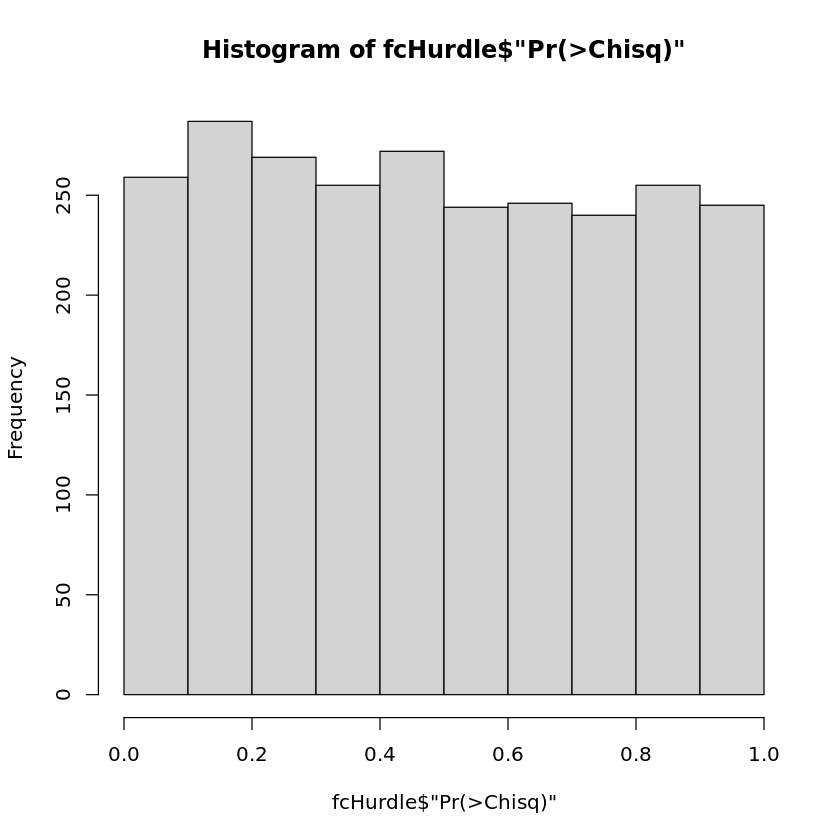

In [31]:
hist(fcHurdle$'Pr(>Chisq)')

In [32]:
write.csv(fcHurdle, '/data_volume/memento/simulation/acc_fpr/mast/MAST_full_demux.csv')

Warning message in file(file, ifelse(append, "a", "w")):
“cannot open file '/data_volume/memento/simulation/acc_fpr/mast/MAST_full_demux.csv': No such file or directory”


ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


### Run mast repeatedly with partial data

In [159]:
data("ifnb")
ifnb <- subset(x = ifnb, subset = seurat_annotations == "CD14 Mono")
ifnb <- NormalizeData(object = ifnb)

In [160]:
cell_list <- colnames(ifnb)
sampled_cells = list()

In [161]:
for (trial in 1:50){
    sampled_cells[[trial]] <- sample(cell_list, size = 250, replace=F)
}

In [162]:

rep_num <- 1
for (trial in 1:2){

    sampled_ifnb <- ifnb[, sampled_cells[[trial]]]
    expressed_genes = rowMeans(as.matrix(GetAssayData(object = sampled_ifnb,slot="counts"))) > 0.07
    scaRaw <- FromMatrix(
        as.matrix(GetAssayData(object = sampled_ifnb,slot="data")), 
        sampled_ifnb[[]], sampled_ifnb[["RNA"]][[]])
    sca <- scaRaw
    sca <- sca[expressed_genes,]
    cond<-factor(colData(sca)$stim)
    cond<-relevel(cond,"CTRL")
    colData(sca)$condition<-cond
    zlmCond <- zlm(~condition + nCount_RNA, sca)
    summaryCond <- summary(zlmCond, doLRT='conditionSTIM')

    summaryDt <- summaryCond$datatable
    fcHurdle <- merge(summaryDt[contrast=='conditionSTIM' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                          summaryDt[contrast=='conditionSTIM' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], by='primerid') #logFC coefficients
    print(colnames(sca)[1:5])
    write.csv(fcHurdle, paste('/data_volume/memento/simulation/acc_fpr/mast/MAST_equal_rep_',trial, '.csv', sep=''))
    }

`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CGGCGATGCCTGTC.1" "TTCTCAGAAAAACG.1" "GGGATTACGGTTAC.1" "AATCCGGATCTCTA.1"
[5] "ACGGCTCTCTGTTT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GTAATAACTATGGC.1" "TAACCGGACTTCCG.1" "CTCCACGACTCGCT.1" "GCTACAGACATTCT.1"
[5] "GCAGCGTGTCCCGT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TAGGTGTGACCCTC.1" "ATCGTTTGTATGGC.1" "TGCAACGATACTGG.1" "ATGCAGACTGGATC.1"
[5] "TACGCCACTGGCAT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TAGGCTGAGCCATA.1" "ACGATTCTTGGAAA.1" "TGCAAGTGTGGTTG.1" "CGACCGGATATTCC.1"
[5] "AAGTAGGATTATCC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "AATCCTTGATGTCG.1" "ATACACCTAAAGTG.1" "TATACAGACCTTCG.1" "AACTCTTGTGTGCA.1"
[5] "GAGCATACGGATCT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TTATGGCTTTCCGC.1" "TATGGGTGTGTCAG.1" "CGGCATCTTAAAGG.1" "CCCGGAGATACTTC.1"
[5] "CCACTTCTAACGTC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CACCACTGTAGAGA.1" "GCAGTCCTATAAGG.1" "GTTGGATGCTCATT.1" "CGCAGGACCATGGT.1"
[5] "GCTACAGATTCAGG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "AGATTCCTCTACTT.1"  "TTTGACTGATCACG.1"  "ATACGGACCGTAGT.11"
[4] "TCTAACTGCACTCC.1"  "AGTCGAACGGGTGA.1" 


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TAGAATACTGCACA.1"  "TAACTCACCATTTC.1"  "GACGTAACCGCTAA.11"
[4] "AGCCAATGCCCTAC.1"  "GATAATACTTCTAC.1" 


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "ACAAATTGGTTGTG.1" "GTCCAAGATCAGGT.1" "CATACTACTGTGCA.1" "TCTATGTGTCTTCA.1"
[5] "GTTTAAGAACACGT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GATTGGACTGGTTG.1" "TCCTAAACCGCATA.1" "TTCATCGATCAGGT.1" "AAGTAGGACAGGAG.1"
[5] "CGATCCACCCTCGT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "AACACTCTTCAAGC.1" "ATCGCCTGAGGAGC.1" "GTATCACTCTAGCA.1" "TGACACGAGTTCGA.1"
[5] "GTTCATACTCGTAG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TGTACTTGAGCGGA.1" "AAAGATCTACCCTC.1" "TCAGGATGTGCATG.1" "TATTGCTGTGACAC.1"
[5] "CAAGGTTGCTTTAC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TGATTCACCGAATC.1" "TTAACCACCTGCAA.1" "TATCTTCTTCTACT.1" "GGACCGTGCAAAGA.1"
[5] "GCCTAGCTTGCCTC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GACGTAACTGCTCC.1" "AGCTTTACAGAATG.1" "TTAGGGTGTTTCGT.1" "CAGGGCACCGGAGA.1"
[5] "ATCCATACATTCCT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TCTAACACGAATGA.1" "AGAATTTGCAACTG.1" "GAAGGGTGCATCAG.1" "TTCATGACCCGTAA.1"
[5] "TTAGACCTAGTGTC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GAGAGGTGAAGGCG.1" "TACCATTGTGCGTA.1" "GGCGACACTTTGGG.1" "ATCACTACTGGTAC.1"
[5] "AAGTGGCTACTGTG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CGAGGCACGTCCTC.1" "CGAAGACTCCTCGT.1" "TAGTCTTGTAGCCA.1" "CAGGGCACGACAGG.1"
[5] "AACTGTCTCTATGG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TAACTCACTTCCCG.1" "TATCACTGTTGTCT.1" "TTCATCGATGAGAA.1" "ATACCTACGTAAGA.1"
[5] "CTGGATGAACAGCT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CATTTGACACTTTC.1" "TACCATTGTCGACA.1" "TTAGTCTGTAGCCA.1" "TATCCAACGAATAG.1"
[5] "ATGAGCACCCTGTC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TAGGTCGACCTATT.1" "AAACATTGTAGCCA.1" "GATCGAACGGGTGA.1" "AGGAAATGGAAACA.1"
[5] "GACAACTGTCGTAG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "ACCAGTGAAGCCTA.1" "GTAGCAACTGTGAC.1" "GCTACAGACTTGCC.1" "TACGAGTGCTACGA.1"
[5] "TTGAACCTCCGTAA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TACCATTGGCTACA.1" "TCGCAAGATGAGAA.1" "ATGGTGACCCCAAA.1" "GCAAACTGCGTAAC.1"
[5] "TAAAGTTGGTCGTA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CCAAGTGAGCTTAG.1" "CGACTCACACGTTG.1" "CTCTAAACGGACAG.1" "TCAGTTACATCGGT.1"
[5] "GAGGACGAGGTTTG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "ACTCTATGGTACGT.11" "CCTAGAGAGGATTC.1"  "GGCGCATGCCTTGC.1" 
[4] "CAGTCAGAGACACT.1"  "ATCTCAACGTCAAC.11"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GAAACAGATGCTCC.1" "ATACGTCTACTCAG.1" "GTAGACTGTTATCC.1" "GGAGGTGAGTGTTG.1"
[5] "CGATAGACGAGGAC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "AGCTGAACGCATCA.1" "AGTGCAACCGGTAT.1" "GGACCCGATCCTAT.1" "GTACAGTGGCTTAG.1"
[5] "CTTATCGATCTCGC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TGAGTCGAGCGTAT.1" "CCGGAGTGTCTGGA.1" "GCTAGAACGAACTC.1" "GACGTATGACAGCT.1"
[5] "GGATTGTGGTGCAT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TCACCCGACGTGTA.1" "GGACCCGACCGTTC.1" "AGCATTCTGACTAC.1" "AGATCGTGACCTTT.1"
[5] "AATCTAGACGACTA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GTTATAGAATTTCC.1" "GGACCGTGTCCGTC.1" "TCGCAAGATGAGAA.1" "GCGTAAACGTTAGC.1"
[5] "CACCACTGTAGAGA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TTCGTATGTTCCGC.1" "AGATTAACGTATCG.1" "CAGATGACGGGCAA.1" "AATGTAACTGCATG.1"
[5] "AGTTTGCTTCAAGC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GGACCCGACCGTTC.1" "TTCGAGGAACGGTT.1" "TCACATACCTTGCC.1" "GCAGCCGACTCCAC.1"
[5] "CCTTAATGGATAGA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "AGCGAACTTATGCG.1" "GCATTGGATCCGAA.1" "CCATGCTGCTGTGA.1" "CGACTGCTAGTACC.1"
[5] "AGAATACTTTCCGC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CGCATAGATCCGTC.1" "TAGCCGCTGAAGGC.1" "TCAGACGAAAGCAA.1" "CCAATGGATGCATG.1"
[5] "CAACGTGAGAGGGT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CCAAGTGATACGAC.1" "GAGGATCTTCACGA.1" "TCGAATCTCCTTCG.1" "ACGCAATGGTCTAG.1"
[5] "TGAGCTGAACCATG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CCCAACTGACGTTG.1" "CTATGTTGTGTTCT.1" "TGAAGCTGCGACAT.1" "TTTATCCTGGAAAT.1"
[5] "ATGGACACCCGCTT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GCTTAACTCCTTGC.1" "AAGAGATGAACAGA.1" "GAAACAGATGGTAC.1" "AAGCCTGAAGCTCA.1"
[5] "AATGTTGACGCAAT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GATTGGACTGTTTC.1" "ACCATTACATGGTC.1" "TCGTAGGACCTTAT.1" "TGTCAGGACATGAC.1"
[5] "ACACCAGAAATCGC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "AATGGAGATCTACT.1" "GTAGACTGGCTGTA.1" "ATTACCTGTCCAGA.1" "TGACCAGATCAGTG.1"
[5] "CAGCATGATGTCAG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "ACGCAATGGTCTAG.1" "TCGACGCTGGCATT.1" "CGACAAACTGTAGC.1" "GATAGAGAAGAAGT.1"
[5] "TGGAAAGAACACCA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "CAATCTACGGTTAC.1" "GCGACTCTAGTGTC.1" "TTCCCACTTGATGC.1" "CTCGCATGTTGACG.1"
[5] "AAGCACTGAGGTCT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "ATCACTTGCTAGCA.1" "ACGATGACGTTACG.1" "GCGTATGATTCATC.1" "GGTAGTACAGTTCG.1"
[5] "GTAGTGACGCCTTC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TATCCTGATGGCAT.1"  "GTTAGGTGGTTGGT.1"  "AGCGGCTGACACGT.1" 
[4] "TCGCACACTGGAAA.11" "GGCCCAGATGCTTT.1" 


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GTGTACGAGAAGGC.1" "AGCCAATGAGTGCT.1" "GTTGATCTACTTTC.1" "CGCTCATGTCAGTG.1"
[5] "CAATAAACGACGGA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "AGTGTTCTTTGCGA.1" "AACATATGGCTCCT.1" "CATGAGACAGGTCT.1" "ATTCAGCTACGTGT.1"
[5] "CGAAGGGATGGTGT.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "ACATGGTGGAATAG.1" "AAGAGATGTGCAAC.1" "GTACGAACACCTAG.1" "CGACCGGAGCGGAA.1"
[5] "TAGCCGCTGAAGGC.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "GATACTCTAACCTG.1" "AGCACAACGACGAG.1" "AGTTTCACACACTG.1" "ATAGCTCTGGATCT.1"
[5] "TGATTCTGGTAGGG.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TAGGAGCTCATTCT.1" "TCGACGCTTGACAC.1" "TAAGGGCTACCTGA.1" "GGAACACTCCGTAA.1"
[5] "AATAAGCTTGTGCA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TTCACCCTTGCACA.1" "AGTTGTCTTCCGAA.1" "ACGCTCACGGTAGG.1" "GTGATGACGCATCA.1"
[5] "AAGAATCTCGTACA.1"


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



[1] "TTCATGTGCTCTAT.1" "ACGCCACTTTCGGA.1" "AACATTGATGGTGT.1" "GCGGAGCTTGAGAA.1"
[5] "AGCATCGATAGCCA.1"


### MAST with partial data

In [169]:
data("ifnb")

In [170]:
ifnb <- subset(x = ifnb, subset = seurat_annotations == "CD14 Mono")

In [171]:
ifnb <- NormalizeData(object = ifnb)

In [172]:
ifnb

An object of class Seurat 
14053 features across 4362 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

In [173]:
ifnb <- subset(ifnb, downsample=1000)

In [174]:
scaRaw <- FromMatrix(
    as.matrix(GetAssayData(object = ifnb,slot="data")), 
    ifnb[[]], ifnb[["RNA"]][[]])

`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.



In [175]:
sca <- scaRaw

In [176]:
# thres <- thresholdSCRNACountMatrix(assay(sca), nbins = 20, min_per_bin = 30)


In [177]:
# freq_expressed <- 0.0005

In [178]:
# assays(sca, withDimnames = FALSE) <- list(thresh=thres$counts_threshold, tpm=assay(sca))
# expressed_genes <- freq(sca) > freq_expressed


In [179]:
sum(expressed_genes)

[1] 6776

In [180]:
sca <- sca[expressed_genes,]

In [181]:
sca

class: SingleCellAssay 
dim: 6776 2000 
metadata(0):
assays(1): et
rownames(6776): NOC2L PLEKHN1 ... NUPR1 CCL18
rowData names(1): primerid
colnames(2000): AAACATTGCTTCGC.1 AAACGCTGGGGATG.1 ... TTTGACTGATCACG.1
  TTTGACTGCCCACT.1
colData names(6): orig.ident nCount_RNA ... seurat_annotations wellKey
reducedDimNames(0):
altExpNames(0):

In [182]:
cond<-factor(colData(sca)$stim)
cond<-relevel(cond,"CTRL")
colData(sca)$condition<-cond
zlmCond <- zlm(~condition + nCount_RNA, sca)


Done!



In [183]:
summaryCond <- summary(zlmCond, doLRT='conditionSTIM')

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [184]:
print(summaryCond, n=4)


Fitted zlm with top 4 genes per contrast:
( log fold change Z-score )
 primerid conditionSTIM nCount_RNA
 CST3       10.1          24.6*   
 CTSB        4.6          25.6*   
 IFI6       56.1*         16.8    
 IFITM3     54.5*          4.5    
 ISG15      62.9*          3.6    
 LY6E       69.3*         11.7    
 PCBP1      -0.9          25.0*   
 UBE2D3      4.6          24.7*   


In [185]:
FCTHRESHOLD <- log2(1.5)


In [186]:
summaryDt <- summaryCond$datatable
fcHurdle <- merge(summaryDt[contrast=='conditionSTIM' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                      summaryDt[contrast=='conditionSTIM' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], by='primerid') #logFC coefficients

fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')]
fcHurdleSig <- merge(fcHurdle[fdr<.05], as.data.table(mcols(sca)), by='primerid')
# setorder(fcHurdleSig, fdr)

In [187]:
write.csv(fcHurdle, 'MAST_2000.csv')

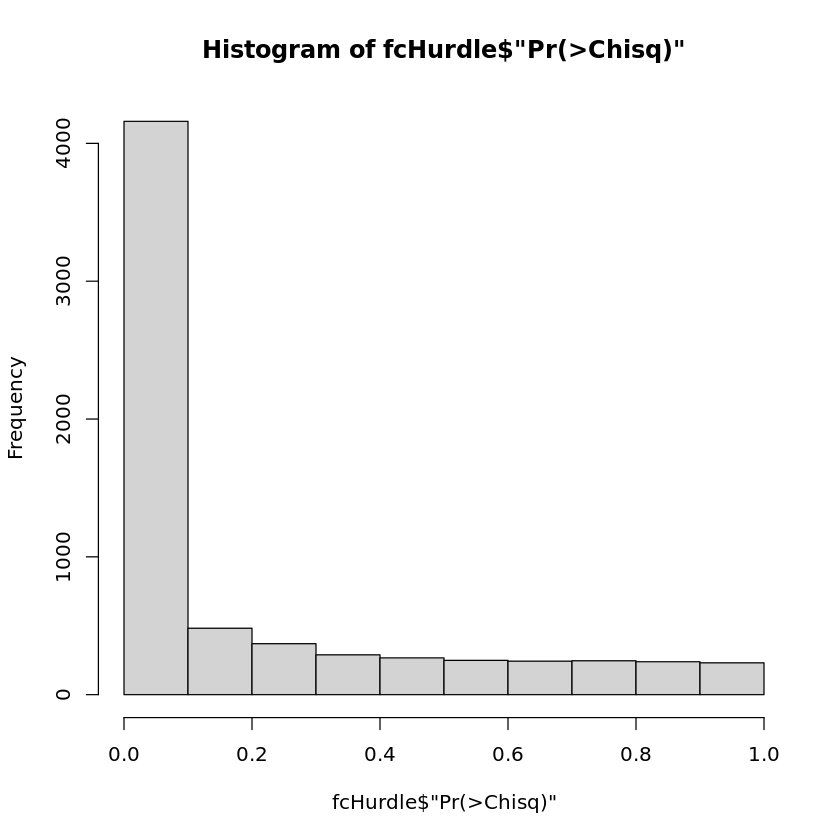

In [188]:
hist(fcHurdle$'Pr(>Chisq)')

### Replication across datasets

#### Demuxlet dataset

In [4]:
data("ifnb")

In [5]:
Idents(ifnb) <- 'seurat_annotations'

In [33]:
expressed_genes = rowMeans(as.matrix(GetAssayData(object = ifnb,slot="counts"))) > 0.02

In [34]:
demux <- subset(x = ifnb,subset = (stim == "CTRL"))
demux <- demux[expressed_genes,]

In [35]:
first.word <- function(my.string){
    unlist(strsplit(my.string, " "))[1]
}

In [36]:
demux$ct_labels <- sub(" .*", "", demux$seurat_annotations)


In [37]:
demux <- subset(x = demux,subset = ct_labels == "CD4" | ct_labels == "CD14")

In [38]:
demux <- NormalizeData(object = demux)

In [39]:
sca <- FromMatrix(
    as.matrix(GetAssayData(object = demux,slot="data")), 
    demux[[]], demux[["RNA"]][[]])

`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.



In [40]:
sca

class: SingleCellAssay 
dim: 5677 4052 
metadata(0):
assays(1): et
rownames(5677): NOC2L HES4 ... HRASLS2 NUPR1
rowData names(1): primerid
colnames(4052): AAACATACATTTCC.1 AAACATACCAGAAA.1 ... TTTGACTGCCGCTT.1
  TTTGACTGTTACCT.1
colData names(7): orig.ident nCount_RNA ... ct_labels wellKey
reducedDimNames(0):
altExpNames(0):

In [41]:
cond<-factor(colData(sca)$ct_labels)
cond<-relevel(cond,"CD14")
colData(sca)$condition<-cond
zlmCond <- zlm(~condition + nCount_RNA, sca)


Done!



In [42]:
summaryCond <- summary(zlmCond, doLRT='conditionCD4')

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [43]:
summaryDt <- summaryCond$datatable
fcHurdle <- merge(summaryDt[contrast=='conditionCD4' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                      summaryDt[contrast=='conditionCD4' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], by='primerid') #logFC coefficients

fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')]
fcHurdleSig <- merge(fcHurdle[fdr<.05], as.data.table(mcols(sca)), by='primerid')
# setorder(fcHurdleSig, fdr)

In [44]:
head(fcHurdle)

primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,4.012881e-02,0.009716967,0.02509193,-0.005657997,4.567186e-02
AAED1,7.221398e-08,-0.044562840,-0.01730714,-0.071818539,1.565923e-07
AAGAB,1.360377e-04,0.015450974,0.02320906,0.007692885,2.070473e-04
AAK1,1.581580e-07,0.044489447,0.06274972,0.026229170,3.307045e-07
AAMDC,6.770855e-01,0.002058178,0.02171198,-0.017595627,6.852940e-01
AAMP,8.135692e-07,0.034055521,0.06526713,0.002843915,1.575787e-06


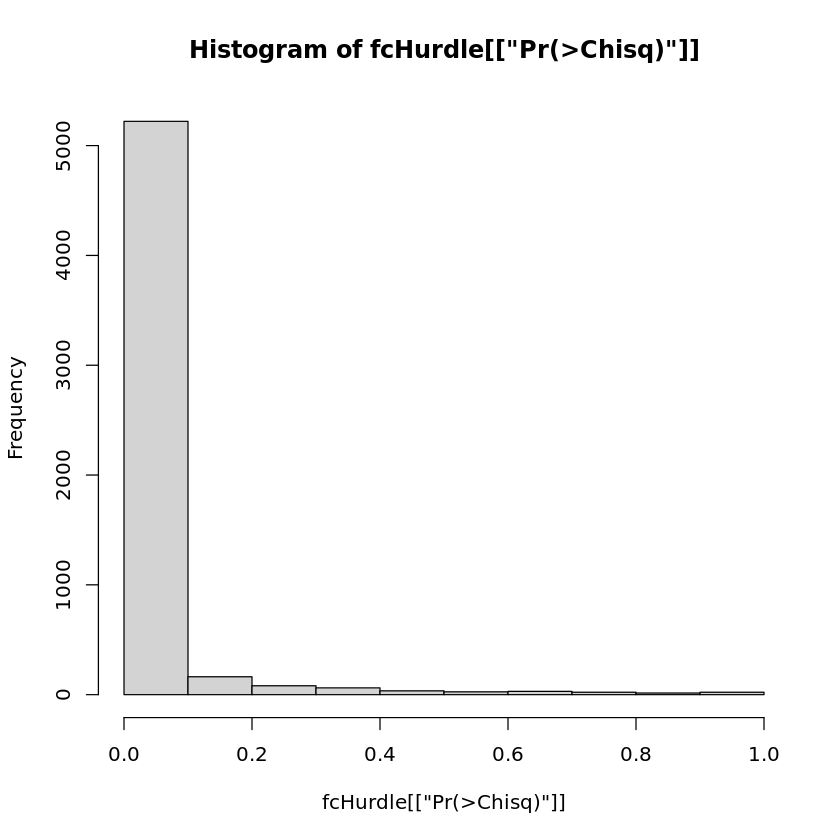

In [45]:
hist(fcHurdle[['Pr(>Chisq)']])

In [46]:
write.csv(fcHurdle, 'MAST_ct_comparison_demux.csv')

In [47]:
write.csv(demux[[]], 'MAST_ct_comparison_cells.csv')

In [48]:
sca

class: SingleCellAssay 
dim: 5677 4052 
metadata(0):
assays(1): et
rownames(5677): NOC2L HES4 ... HRASLS2 NUPR1
rowData names(1): primerid
colnames(4052): AAACATACATTTCC.1 AAACATACCAGAAA.1 ... TTTGACTGCCGCTT.1
  TTTGACTGTTACCT.1
colData names(8): orig.ident nCount_RNA ... wellKey condition
reducedDimNames(0):
altExpNames(0):

#### PBMC3k dataset

In [49]:
# InstallData("pbmc3k")


In [50]:
data("pbmc3k")

In [51]:
expressed_genes = rowMeans(as.matrix(GetAssayData(object = pbmc3k,slot="counts"))) > 0.02

In [52]:
pbmc3k <- NormalizeData(object = pbmc3k)
pbmc3k <- pbmc3k[expressed_genes,]

In [53]:
first.word <- function(my.string){
    first <- unlist(strsplit(my.string, " "))[1]
    second <- unlist(strsplit(my.string, " "))[2]
    if (is.na(first)){
        return('ELSE')
    }
    if (first == 'CD14+'){
        return('CD14')
    }
    if (is.na(second)){
        return('ELSE')
    }
    if (second == 'CD4'){
        return('CD4')
    }
    return('ELSE')
}

In [54]:
pbmc3k$ct_labels <- sapply(as.vector(pbmc3k$seurat_annotations), first.word)

In [55]:
sca <- FromMatrix(
    as.matrix(GetAssayData(object = pbmc3k,slot="data")), 
    pbmc3k[[]], pbmc3k[["RNA"]][[]])

`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.

Assuming data assay in position 1, with name et is log-transformed.



In [56]:
cond<-factor(colData(sca)$ct_labels)
cond<-relevel(cond,"CD14")
colData(sca)$condition<-cond
zlmCond <- zlm(~condition + nCount_RNA, sca)

Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numer

In [57]:
summaryCond <- summary(zlmCond, doLRT='conditionCD4')

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...

Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probabilities numerically 0 or 1 occurred”
Warning message in .bayesglm.fit.loop.printWarnings(Warning, state, family):
“fitted probab

In [58]:
summaryDt <- summaryCond$datatable
fcHurdle <- merge(summaryDt[contrast=='conditionCD4' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                      summaryDt[contrast=='conditionCD4' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], by='primerid') #logFC coefficients

fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')]
fcHurdleSig <- merge(fcHurdle[fdr<.05], as.data.table(mcols(sca)), by='primerid')
# setorder(fcHurdleSig, fdr)

In [59]:
head(fcHurdle)

primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,9.128088e-01,-0.0001070671,0.02957264,-0.029786775,9.468831e-01
AAAS,2.479021e-01,0.0080933301,0.02254140,-0.006354735,3.783401e-01
AAED1,3.771149e-06,-0.0720544319,-0.03239617,-0.111712696,1.848231e-05
AAGAB,9.159206e-01,-0.0055434392,0.02825157,-0.039338444,9.484847e-01
AAK1,1.996694e-22,0.2986867325,0.37273580,0.224637665,2.863830e-21
AAMDC,6.757721e-01,0.0029074651,0.02748086,-0.021665931,7.834587e-01


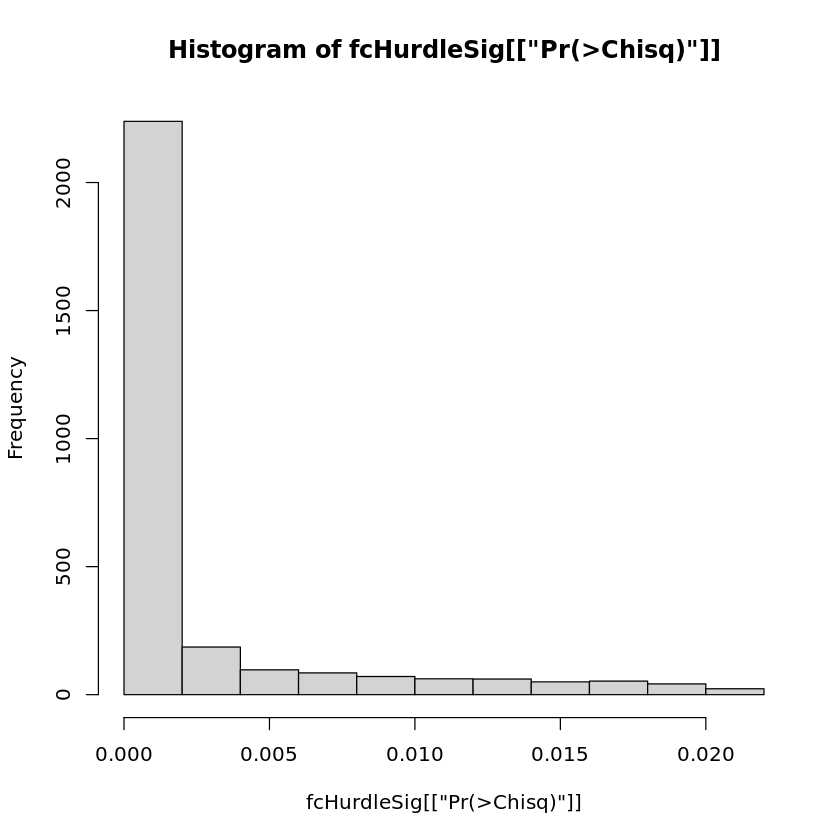

In [60]:
hist(fcHurdleSig[['Pr(>Chisq)']])

In [61]:
write.csv(fcHurdle, 'MAST_ct_comparison_pbmc3k.csv')

In [62]:
write.csv(demux[[]], 'MAST_ct_comparison_cells_pbmc3k.csv')

### IFNB

In [16]:
RemoveData('ifnb')

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning me

In [1]:
library('edgeR')

Loading required package: limma



In [6]:
data("ifnb")

In [7]:
ifnb <- subset(x = ifnb, subset = seurat_annotations == "CD14 Mono")

In [8]:
ifnb <- NormalizeData(object = ifnb)

In [9]:
ifnb$stim = sample(as.vector(ifnb$stim))

In [96]:
ifnb$replicate = sample.int(2, dim(ifnb)[2], replace=TRUE)

In [11]:
expressed_genes = rowMeans(as.matrix(GetAssayData(object = ifnb,slot="counts"))) > 0.07

In [12]:
subset(ifnb[expressed_genes,], subset=stim=='CTRL')

An object of class Seurat 
2572 features across 2215 samples within 1 assay 
Active assay: RNA (2572 features, 0 variable features)

In [15]:
head(ifnb[[]], 10)

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations
,<chr>,<dbl>,<int>,<chr>,<fct>
AAACATACATTTCC.1,IMMUNE_CTRL,3017,877,CTRL,CD14 Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481,713,CTRL,CD14 Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420,850,CTRL,CD14 Mono
AAACATACGGCATT.1,IMMUNE_CTRL,1581,557,STIM,CD14 Mono
AAACATTGCTTCGC.1,IMMUNE_CTRL,2536,669,CTRL,CD14 Mono
AAACGCACTCGCCT.1,IMMUNE_CTRL,3563,908,STIM,CD14 Mono
AAACGCTGGGACAG.1,IMMUNE_CTRL,2998,847,STIM,CD14 Mono
AAACGCTGGGGATG.1,IMMUNE_CTRL,1459,510,STIM,CD14 Mono
AAACGGCTAGAGTA.1,IMMUNE_CTRL,3606,969,CTRL,CD14 Mono


In [13]:
head(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='STIM'), slot="counts"))

   [[ suppressing 2147 column names ‘AAACATACGGCATT.1’, ‘AAACGCACTCGCCT.1’, ‘AAACGCTGGGACAG.1’ ... ]]



6 x 2147 sparse Matrix of class "dgCMatrix"
                                                                              
HES4     . . . . . . . . . . . . . . . . . . . . .  .  . . . . . . . . . . . .
ISG15    3 3 . . . . . . . . . . . 1 . . . 3 . . 1 21 12 . 1 . . 2 . . 1 1 . .
SDF4     . . . . . 1 . . . . . . . . . . . . 1 . .  .  . . . 1 . . . 1 . . . .
UBE2J2   1 . . . . . . . . . . . . . . . . 1 . . .  .  1 . . . . . . 1 1 . . .
AURKAIP1 . . . 1 . 1 2 . 2 . . . . 1 1 1 1 1 1 . 1  .  . 2 . . 1 . . . 2 . 1 .
MRPL20   . . . . . . . . . 1 . . 1 1 . . . 2 . . 1  1  2 . . . . . . . . . . .
                                                                               
HES4     . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ISG15    . . 13 . . . 1 . . . 1 2 . . . . 7 . . 4 4 . . 1 2 . 1 1 . 1 . . 1 . 4
SDF4     . .  1 . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . 1 .
UBE2J2   . .  . . . . 1 . . . . . . . . . . 1 1 . . . . . . . . . 1 . 1 . . 1 .
AUR

In [80]:
stim_data_1 = rowMeans(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='STIM'), slot='counts'))
ctrl_data_1 = rowMeans(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='CTRL'), slot='counts'))

stim_data_2 = rowSums(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='STIM' & replicate==2), slot='counts'))
ctrl_data_2 = rowSums(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='CTRL' & replicate==2), slot='counts'))

In [81]:
head(stim_data_1)

HES4       ISG15        SDF4      UBE2J2    AURKAIP1      MRPL20 
 0.59198882 65.48952026  0.10666046  0.09967396  0.42850489  0.20307406

In [82]:
head(ctrl_data_1)

HES4      ISG15       SDF4     UBE2J2   AURKAIP1     MRPL20 
 0.6058691 62.2207675  0.1137698  0.1038375  0.4577878  0.1869074

In [53]:
stim_data_1 = rowSums(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='STIM' & replicate==1), slot='counts'))
ctrl_data_1 = rowSums(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='CTRL' & replicate==1), slot='counts'))

stim_data_2 = rowSums(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='STIM' & replicate==2), slot='counts'))
ctrl_data_2 = rowSums(GetAssayData(subset(ifnb[expressed_genes,], subset=stim=='CTRL' & replicate==2), slot='counts'))

In [55]:
x = data.frame(stim_data_1, ctrl_data_1, stim_data_2, ctrl_data_2)

In [56]:
group <- factor(c(1,2, 1,2))


In [57]:
y <- DGEList(counts=x,group=group)

In [58]:
keep <- filterByExpr(y)

In [59]:
y <- y[keep,,keep.lib.sizes=FALSE]

In [60]:
y <- calcNormFactors(y)

In [61]:
design <- model.matrix(~group)

In [62]:
y <- estimateDisp(y,design)

In [64]:
fit <- glmFit(y,design)

In [65]:
lrt <- glmLRT(fit,coef=2)

In [67]:
lrt

An object of class "DGELRT"
$coefficients
         (Intercept)      group2
HES4       -8.349271  0.02822977
ISG15      -3.643306 -0.04622177
SDF4      -10.062225  0.06972653
UBE2J2    -10.129898  0.04632321
AURKAIP1   -8.672382  0.07129568
2567 more rows ...

$fitted.values
         stim_data_1 ctrl_data_1 stim_data_2 ctrl_data_2
HES4        635.5930    660.2252    635.4060    681.4509
ISG15     70313.2719  67797.5532  70292.5821  69977.1859
SDF4        114.5168    124.0033    114.4831    127.9899
UBE2J2      107.0155    113.1977    106.9840    116.8369
AURKAIP1    460.0676    498.9345    459.9322    514.9749
2567 more rows ...

$deviance
     HES4     ISG15      SDF4    UBE2J2  AURKAIP1 
1.9057330 2.3972279 0.3438686 2.9633040 0.3076967 
2567 more elements ...

$method
[1] "oneway"

$unshrunk.coefficients
         (Intercept)      group2
HES4       -8.349465  0.02823521
ISG15      -3.643308 -0.04622185
SDF4      -10.063302  0.06979913
UBE2J2    -10.131050  0.04637526
AURKAIP1   -8.672

In [69]:
result = as.data.frame(lrt)

In [70]:
head(result)

,logFC,logCPM,LR,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
HES4,0.04072695,7.910993,0.3423594,0.55847050
ISG15,-0.06668392,14.642456,5.1602871,0.02310908
SDF4,0.10059412,5.488924,0.5551848,0.45620687
UBE2J2,0.06683026,5.375491,0.2013390,0.65364220
AURKAIP1,0.10285792,7.478436,1.7748643,0.18278123
MRPL20,-0.11199384,6.300197,1.1190282,0.29012781


In [72]:
result$Pvalue

NULL

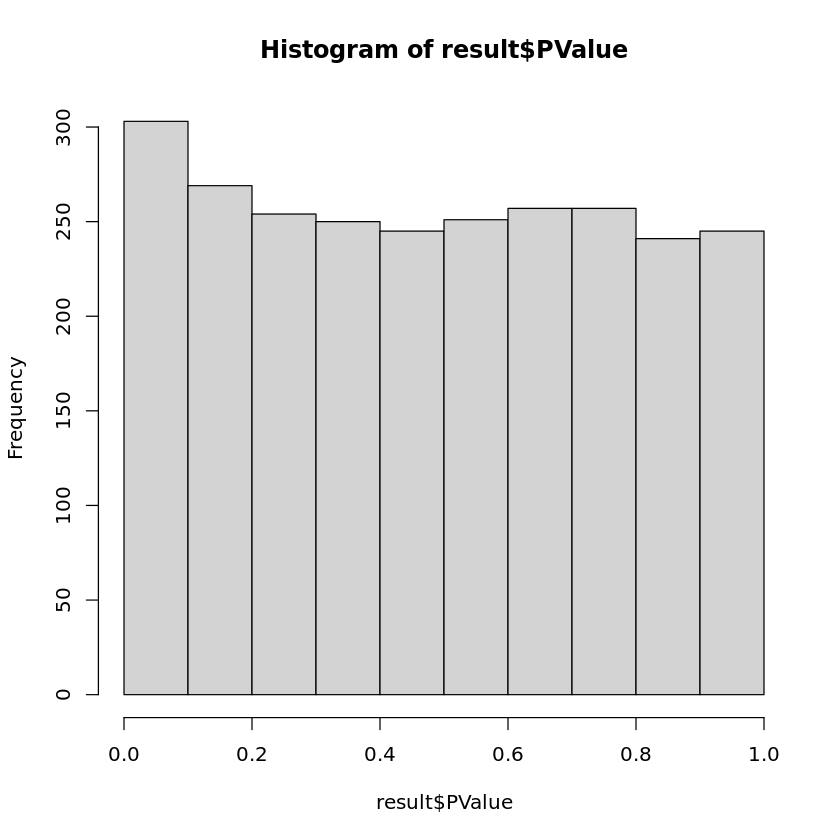

In [73]:
hist(result$PValue)

In [66]:
topTags(lrt)

,logFC,logCPM,LR,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HBB,-0.6569585,6.861070,19.68937,9.110696e-06,0.02343271
GZMB,-0.7188433,4.926137,17.36478,3.084890e-05,0.02956823
SERPINB2,-0.4235624,7.640719,17.15288,3.448860e-05,0.02956823
IL1B,0.2409559,8.874597,14.41098,1.469429e-04,0.09448430
GTF2E2,-0.4639767,5.717859,13.39070,2.528746e-04,0.13007869
MMP19,-0.5290644,5.317047,12.93458,3.225671e-04,0.13132701
MSRB2,0.5130298,5.413136,12.72109,3.615545e-04,0.13132701
TSC22D4,-0.3618179,6.480369,12.42814,4.229123e-04,0.13132701
HNRNPA0,-0.2908342,7.193201,12.12085,4.986109e-04,0.13132701
